d:\Anaconda\envs\dl2025-py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


读取数据...
删除缺失率超过20%的列: ['Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min', 'Heat_Index']
进行特征构造和处理...
划分训练集和测试集...
进行 SMOTETomek 采样...


[I 2025-07-30 00:36:03,199] A new study created in memory with name: no-name-5096c768-b0cb-4a38-bb8a-ce477fe35f6c


开始超参数调优...


Optuna Trials:   0%|          | 0/20 [00:00<?, ?it/s]d:\Anaconda\envs\dl2025-py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:36:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Anaconda\envs\dl2025-py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:36:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Anaconda\envs\dl2025-py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:36:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Anaconda\envs\dl2025-py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:36:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:

最佳参数: {'max_depth': 10, 'learning_rate': 0.21233901339456307, 'n_estimators': 499, 'subsample': 0.6079830846026631, 'colsample_bytree': 0.8888395668271638, 'gamma': 2.194815864562343, 'reg_alpha': 2.265291571627213, 'reg_lambda': 4.3488606526652545}
训练最终模型...


d:\Anaconda\envs\dl2025-py311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:39:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


优化阈值并绘制图像...


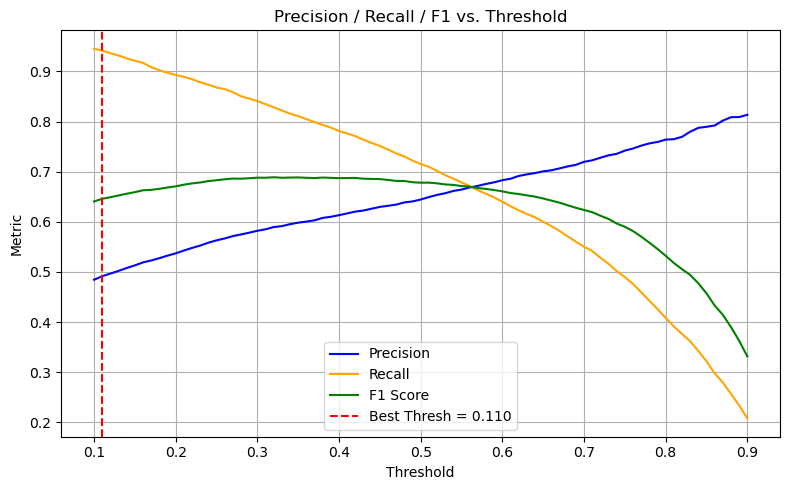

最佳阈值: 0.110
评估模型...
Accuracy: 0.937662
Recall: 0.941432
F1 Score: 0.645935

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.94      0.97     75168
        True       0.49      0.94      0.65      4832

    accuracy                           0.94     80000
   macro avg       0.74      0.94      0.81     80000
weighted avg       0.97      0.94      0.95     80000

ROC-AUC: 0.980179

Top 5 Feature Importance:
 Operational_Hours            0.601075
Maintenance_History_Count    0.022815
Error_Codes_Last_30_Days     0.020360
Failure_History_Count        0.018573
Machine_Type_Robot_Arm       0.010255
dtype: float32


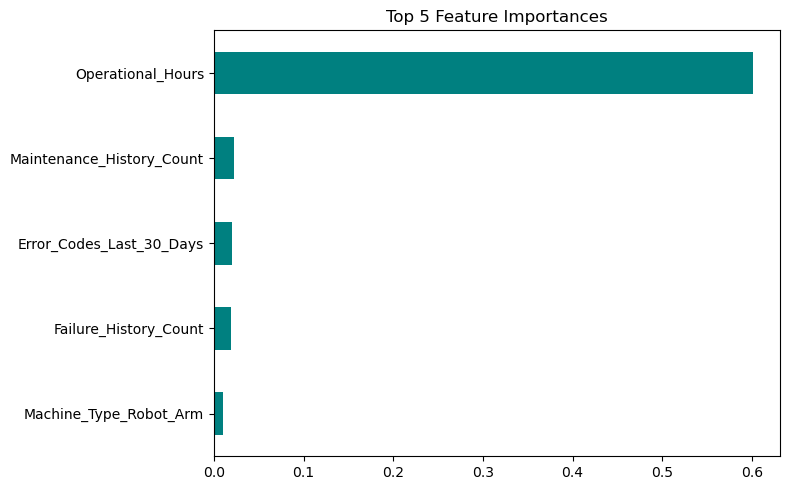

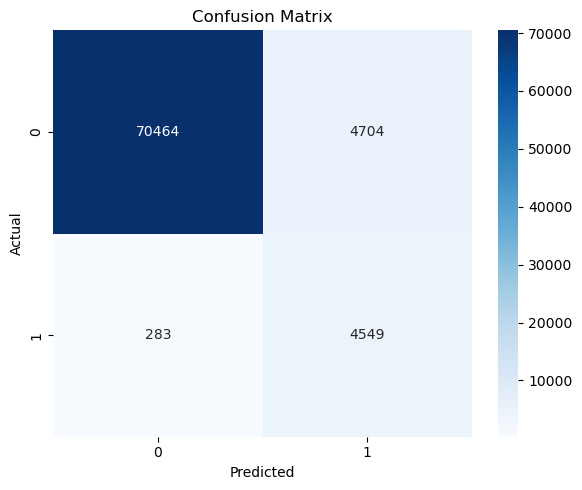

计算并可视化 SHAP 值...


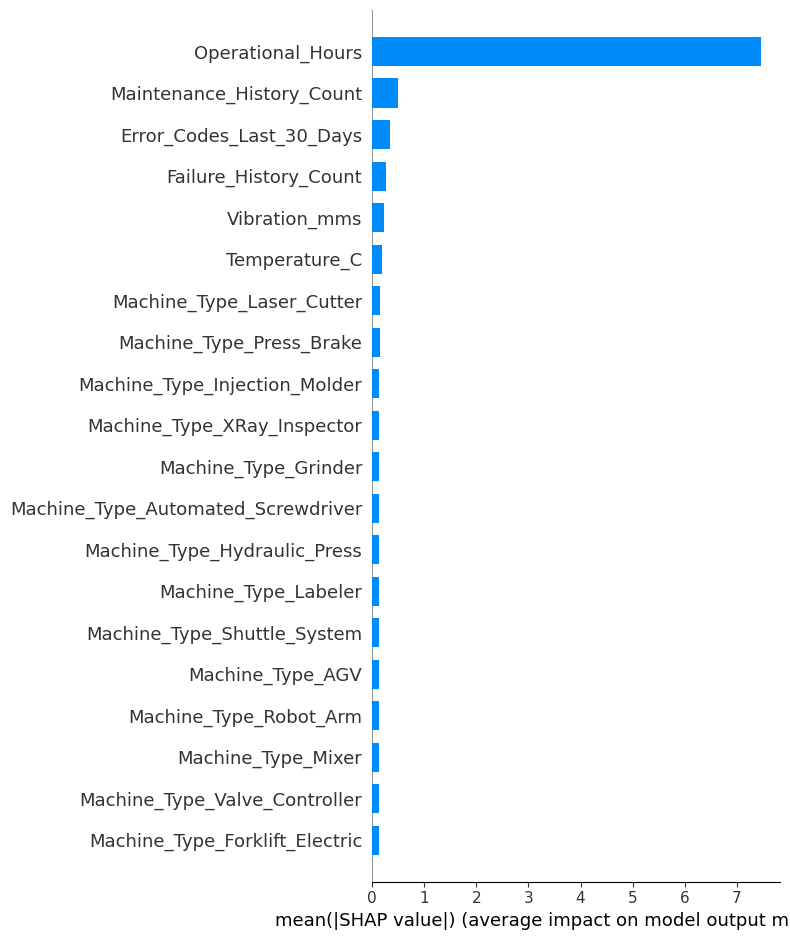

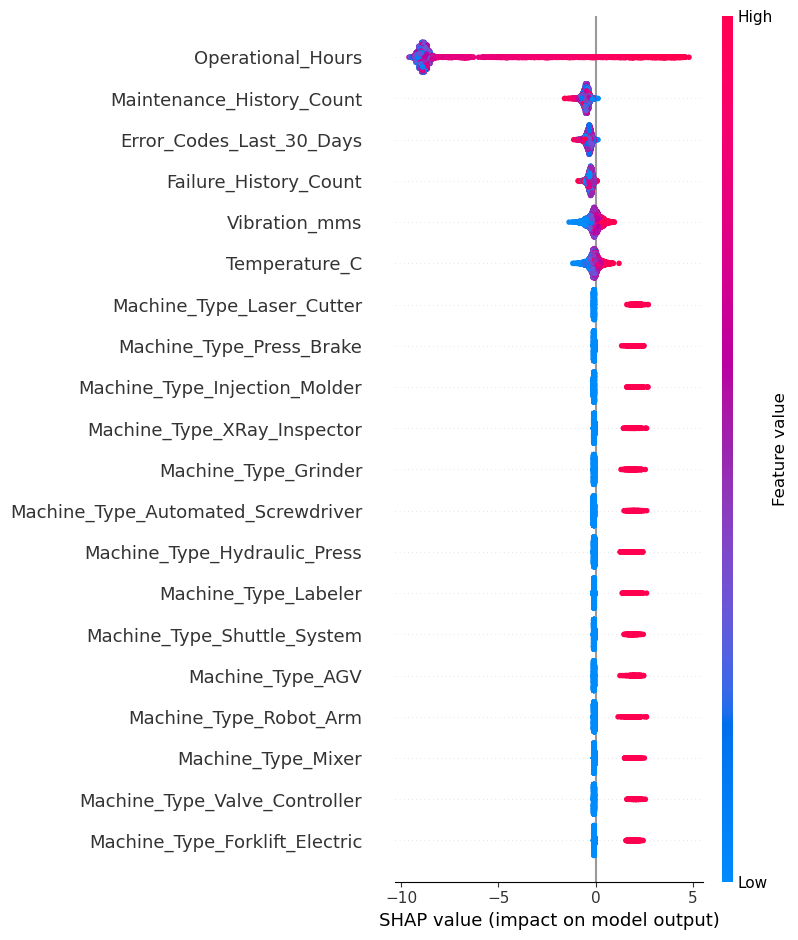

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ===================== 1. 数据读取 =====================
print("读取数据...")
df = pd.read_csv(r"D:\桌面\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\2025年第四届“创新杯”（原钉钉杯）大学生大数据挑战赛初赛题目\A题\data\train_data.csv")

# ===================== 2. 缺失值处理 =====================
missing_ratio = df.isnull().mean()
drop_missing_cols = missing_ratio[missing_ratio > 0.2].index.tolist()
print(f"删除缺失率超过20%的列: {drop_missing_cols}")
df.drop(columns=drop_missing_cols, inplace=True)

df.drop(columns=['Machine_ID', 'Remaining_Useful_Life_days', 'Installation_Year'], errors='ignore', inplace=True)

# ===================== 3. 异常值处理（缩尾处理） =====================
def winsorize_series(series, lower_pct=0.01, upper_pct=0.99):
    lower = series.quantile(lower_pct)
    upper = series.quantile(upper_pct)
    return np.clip(series, lower, upper)

# 拆分标签
y = df['Failure_Within_7_Days']
df.drop(columns=['Failure_Within_7_Days'], inplace=True)

# 异常值处理（对数值特征）
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    df[col] = winsorize_series(df[col])

# ===================== 4. 特征工程 =====================
print("进行特征构造和处理...")
df = pd.get_dummies(df, columns=['Machine_Type'], drop_first=True)

X = df.copy()

# ===================== 5. 标准化 =====================
num_features = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# ===================== 6. 数据划分 =====================
print("划分训练集和测试集...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ===================== 7. SMOTETomek 重采样 =====================
print("进行 SMOTETomek 采样...")
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

# ===================== 8. Optuna 超参数调优 =====================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    model = XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring='f1')
    return scores.mean()

print("开始超参数调优...")
study = optuna.create_study(direction='maximize')
for _ in tqdm(range(20), desc='Optuna Trials'):
    study.optimize(objective, n_trials=1, show_progress_bar=False)
best_params = study.best_params
print("最佳参数:", best_params)

# ===================== 9. 模型训练 =====================
print("训练最终模型...")
model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_res, y_train_res)

# ===================== 10. 阈值优化 + 三曲线绘图 =====================
def plot_threshold_metrics(model, X_val, y_val):
    y_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 81)
    precisions, recalls, f1s = [], [], []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))

    best_idx = np.argmax(np.array(f1s) + np.array(recalls))
    best_threshold = thresholds[best_idx]

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precisions, label='Precision', color='blue')
    plt.plot(thresholds, recalls, label='Recall', color='orange')
    plt.plot(thresholds, f1s, label='F1 Score', color='green')
    plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best Thresh = {best_threshold:.3f}')
    plt.title("Precision / Recall / F1 vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Metric")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_threshold

print("优化阈值并绘制图像...")
best_threshold = plot_threshold_metrics(model, X_test, y_test)
print(f"最佳阈值: {best_threshold:.3f}")

# ===================== 11. 模型评估 =====================
print("评估模型...")
y_pred = (model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

print("Accuracy:", round((y_pred == y_test).mean(), 6))
print("Recall:", round(recall_score(y_test, y_pred), 6))
print("F1 Score:", round(f1_score(y_test, y_pred), 6))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 6))

# ===================== 12. 特征重要性分析 =====================
importance = pd.Series(model.feature_importances_, index=X.columns)
top5 = importance.sort_values(ascending=False).head(5)
print("\nTop 5 Feature Importance:\n", top5)

plt.figure(figsize=(8,5))
top5.plot(kind='barh', color='teal')
plt.title("Top 5 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ===================== 13. 混淆矩阵 =====================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ===================== 14. SHAP解释 =====================
print("计算并可视化 SHAP 值...")
X_sample = X_test.sample(n=min(5000, len(X_test)), random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")
shap.summary_plot(shap_values, X_sample)


In [3]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, df['Operational_Hours'])


0.9817879392833538